v2 + :
- multi-head self-attention
- feed forward (MLP)

Source:
- https://youtu.be/kCc8FmEb1nY?t=4922
- https://github.com/karpathy/ng-video-lecture/blob/master/bigram.py


<img src="../assets/transformer.png" width="600"/>

In [1]:
import os; os.chdir('..')
import numpy as np
import matplotlib.pyplot as plt 
import torch
from torch import nn
from torch.nn import functional as F
import math

from utils import *
from boring_utils.utils import init_graph, set_seed, get_device, cprint, tprint
from utils import add_to_class

In [3]:
init_graph()
set_seed(1337)
device = get_device()

# Hyperparameters

In [5]:
set_seed(1337)
batch_size = 32 # how many independent sequences to train on in parallel
block_size = 8  # what is the maximum concatenated length for predictions
max_iters = 3000
eval_interval = 300
learning_rate = 1e-3
device = get_device()
eval_iters = 200
n_embed = 32
dropout = 0.2

# Encode and Decode Funcion

In [6]:
input_file_path = './data/shakespeare_char/input.txt'

with open(input_file_path, 'r') as f:
    data = f.read()
print(f"length of dataset in characters: {len(data):,}")

# get all the unique characters that occur in this text
chars = sorted(list(set(data)))
vocab_size = len(chars)
print("all the unique characters:", ''.join(chars))
print(f"vocab size: {vocab_size:,}")

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
print("stoi:", stoi)
print("itos:", itos)

def encode(s):
    return [stoi[c] for c in s] # encoder: take a string, output a list of integers

def decode(l):
    return ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

length of dataset in characters: 1,115,394
all the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65
stoi: {'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}
itos: {0: '\n', 1: ' ', 2: '!', 3: '$', 4: '&', 5: "'", 6: ',', 7: '-', 8: '.', 9: '3', 10: ':', 11: ';', 12: '?', 13: 'A', 14: 'B', 15: 'C', 16: 'D', 17: 'E', 18: 'F', 19: 'G', 20: 'H', 21: 'I', 22: 'J', 23: 'K', 24: 'L', 25: 'M', 26: 'N', 27: 'O', 28: 'P', 29: 'Q'

In [7]:
def test_decode(net, max_new_tokens=100):
    gen = net.generate(
            torch.zeros((1, 1), dtype=torch.long, device=device),
            max_new_tokens=max_new_tokens
        )
    print(gen)
    print(decode(gen[0].tolist()))

In [8]:
train_bin_path = './data/shakespeare_char/train.bin'
val_bin_path = './data/shakespeare_char/val.bin'

# train_tensor = torch.tensor(encode(data), dtype=torch.long) # convert to tensor

# torch.long is just an alias for torch.int64
# load the binary data
train_data = np.fromfile(train_bin_path, dtype=np.uint16)
val_data = np.fromfile(val_bin_path, dtype=np.uint16)

# convert to pytorch tensors
train_tensor = torch.from_numpy(train_data.astype(np.int64))
val_tensor = torch.from_numpy(val_data.astype(np.int64))

print(train_tensor.shape, train_tensor.dtype)
print(val_tensor.shape, val_tensor.dtype)


torch.Size([1003854]) torch.int64
torch.Size([111540]) torch.int64


# Attention

checkout `attention.ipynb`

In [9]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

## Simple Multi-Head Self-Attention

Communication part

In [10]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        return out

# Feed Forward Block

Per-token level

In [11]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, n_embd),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

# NN with Multihead-Attention

The way we use `MultiHeadAttention` is kind like group conv

In [12]:
class BigramLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, n_embed)
        self.position_embedding = nn.Embedding(block_size, n_embed)
        # self.sa_head = Head(n_embed)  # self-attention head
        self.sa_head = MultiHeadAttention(4, n_embed // 4)  # 4 heads of 8-dim self-attention
        self.ffwd = FeedFoward(n_embed)  # put ffwd (pre token computation) after attention (communication)
        self.lm_head = nn.Linear(n_embed, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape  # B: batch_size, T: block_size

        # idx is (batch_size, block_size)
        tok_emb = self.token_embedding(idx)  # B, T, C: (batch_size, block_size, embedding_dim)
        pos_emb = self.position_embedding(torch.arange(T, device=device))  # T, C: (block_size, embedding_dim)
        x = tok_emb + pos_emb  # B, T, C: (batch_size, block_size, embedding_dim)
        x = self.sa_head(x)  # B, T, C: (batch_size, block_size, embedding_dim)
        x = self.ffwd(x)  # B, T, C: (batch_size, block_size, embedding_dim)
        # logits = self.lm_head(tok_emb)  # B, T, V: (batch_size, block_size, vocab_size)
        logits = self.lm_head(x)  # B, T, V: (batch_size, block_size, vocab_size)

        if targets == None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)  # (batch_size * block_size, embedding_dim)
            targets = targets.view(-1)  # (batch_size * block_size)
            loss = F.cross_entropy(logits, targets)

        return logits, loss


In [13]:
# in prepare.py, we have:
# chars = sorted(list(set(data)))
# vocab_size = len(chars)

m = BigramLanguageModel()
m.to(device)
# logits, loss = m(xb, yb)
# print(logits.shape, logits.dtype)
# print(loss)  # so currently this is worse than random guessing

BigramLanguageModel(
  (token_embedding): Embedding(65, 32)
  (position_embedding): Embedding(8, 32)
  (sa_head): MultiHeadAttention(
    (heads): ModuleList(
      (0-3): 4 x Head(
        (key): Linear(in_features=32, out_features=8, bias=False)
        (query): Linear(in_features=32, out_features=8, bias=False)
        (value): Linear(in_features=32, out_features=8, bias=False)
        (dropout): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (ffwd): FeedFoward(
    (net): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
    )
  )
  (lm_head): Linear(in_features=32, out_features=65, bias=True)
)

In [14]:
@add_to_class(BigramLanguageModel)
def generate(self, idx, max_new_tokens):
    # idx is (batch_size, block_size)
    for _ in range(max_new_tokens):
        # new: crop idx to the last block_size tokens
        # mainly to avoid errors for self.position_embedding
        idx_cond = idx[:, -block_size:]  # (batch_size, block_size)

        # get the predictions
        # logits, _ = self.forward(idx, None)
        # logits, _ = self(idx)
        logits, _ = self(idx_cond)

        # focus only the last time stemp
        logits = logits[:, -1, :]  # (batch_size, embedding_dim)
        probs = F.softmax(logits, dim=-1)

        # sample from distrubution
        idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # append sampled idx to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, T + 1)

    return idx

In [15]:
test_decode(m)

tensor([[ 0, 62, 38,  8, 32, 32, 23, 28, 14,  9, 60,  9, 12,  0, 34, 36, 55, 19,
         18,  2, 43, 41, 35, 17, 62, 59, 30, 58, 42,  2, 35, 50, 43, 37, 52, 11,
         20, 56, 57, 11, 19, 35, 48, 43, 52, 29, 46, 41, 40, 59, 47, 33, 25, 28,
         63, 48, 60, 49, 55, 26, 49, 35, 18, 15,  9, 31, 25, 17, 18, 18, 24, 43,
         20, 49, 60, 35, 53, 29, 51,  6, 44,  3, 25, 16,  5, 26, 26, 39, 40,  0,
         39,  2, 18, 59, 26, 39, 63, 59,  4, 17, 22]], device='cuda:0')

xZ.TTKPB3v3?
VXqGF!ecWExuRtd!WleYn;Hrs;GWjenQhcbuiUMPyjvkqNkWFC3SMEFFLeHkvWoQm,f$MD'NNab
a!FuNayu&EJ


# Training the NN

[torch.optim.Optimizer.zero_grad — PyTorch 2.0 documentation](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html)

In [16]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [17]:
loss_list = []

for steps in range(max_iters):
    if steps % eval_interval == 0 or iter == max_iters - 1:
        # in fp16 mode, we use autocast to automatically cast the data to half precision
        # ctx = nullcontext() if device == 'cpu' else torch.amp.autocast(device_type=device, dtype=ptdtype)
        losses = estimate_loss_np(m, eval_iters, train_data, val_data, block_size=block_size, batch_size=batch_size, device=device)
        # losses = estimate_loss(m)
        print(f"step: {steps}, train loss: {losses['train']:.4f}, val loss: {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch_np(train_data, block_size=block_size, batch_size=batch_size, device=device)

    # evaluate the loss
    logits, loss = m(xb, yb)
    # interesting...
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    if steps % 200 == 0:
        loss_list.append(loss.item())


step: 0, train loss: 4.2022, val loss: 4.2019
step: 300, train loss: 2.8104, val loss: 2.8251
step: 600, train loss: 2.6048, val loss: 2.6177
step: 900, train loss: 2.5262, val loss: 2.5158
step: 1200, train loss: 2.4723, val loss: 2.4699
step: 1500, train loss: 2.4217, val loss: 2.4290
step: 1800, train loss: 2.3965, val loss: 2.4061
step: 2100, train loss: 2.3703, val loss: 2.3791
step: 2400, train loss: 2.3531, val loss: 2.3762
step: 2700, train loss: 2.3311, val loss: 2.3516


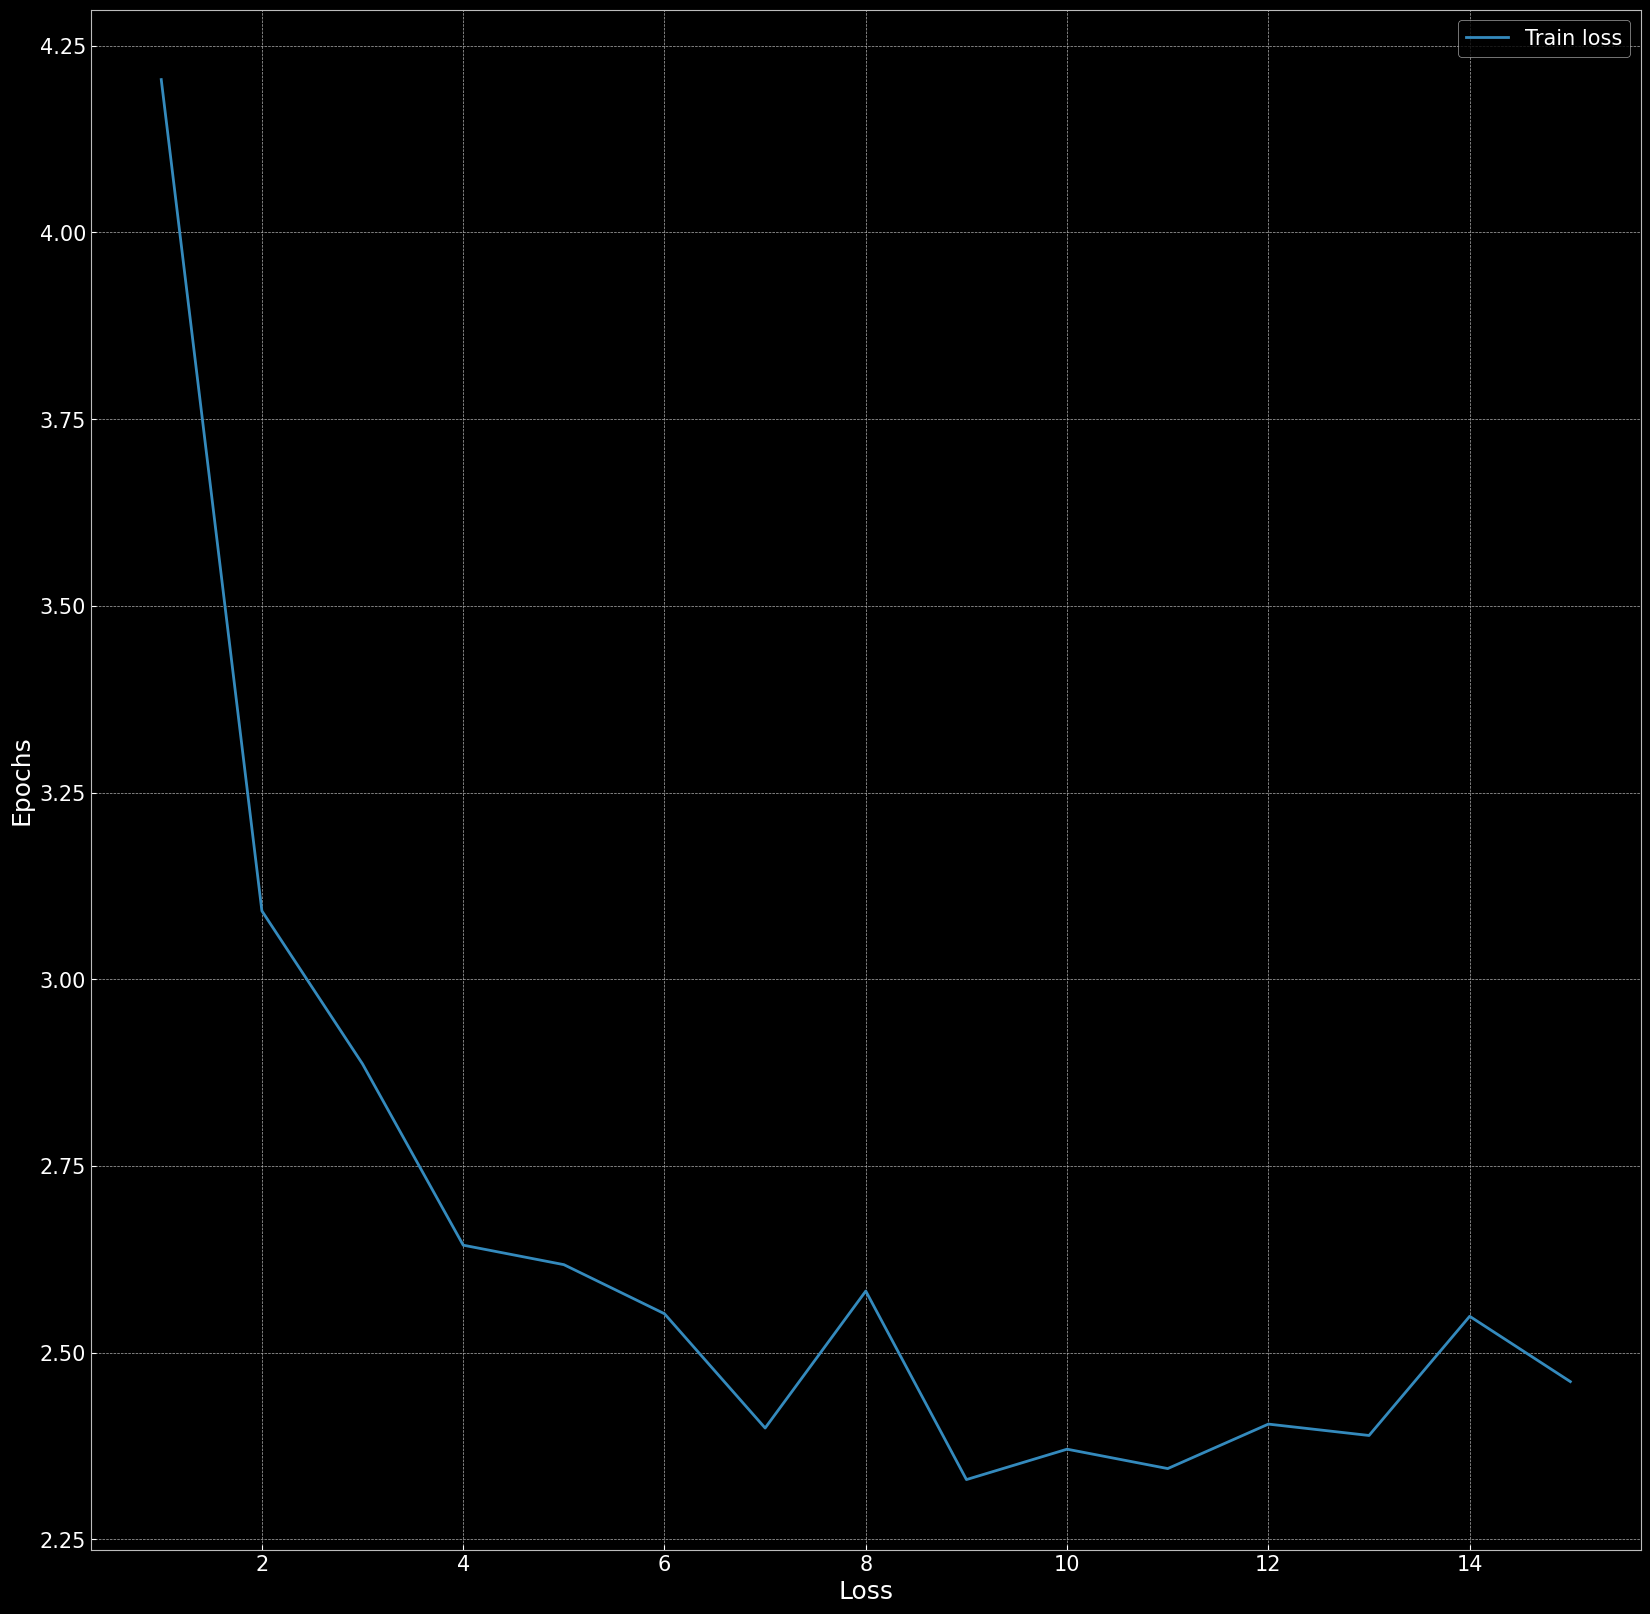

In [18]:
fig = plt.figure(figsize=(20, 20))
plt.plot(np.arange(1, len(loss_list) + 1), loss_list, label="Train loss")
plt.xlabel("Loss")
plt.ylabel("Epochs")
plt.legend(loc="upper right")

plt.show()

In [19]:
test_decode(m, 500)

tensor([[ 0, 24, 21, 37, 10,  0, 13, 16, 46, 30, 43, 47, 52,  1, 40, 54, 63, 47,
         53, 60, 47, 58,  1, 58, 46, 43, 63,  1, 52, 53, 59, 56, 47, 43,  1, 58,
         39, 58, 46,  1, 58, 46, 43,  1, 53, 63,  1, 57, 46, 39,  1, 58, 54, 46,
          1, 39, 57, 43,  1, 58, 46, 47, 50, 50, 50, 43, 50, 50, 50, 47, 57,  1,
         58, 46, 43, 39, 56, 52,  6,  0, 24,  1, 46, 53, 58, 56, 43,  1, 39, 52,
         43, 50,  1, 39, 52, 63,  7, 44,  6,  1, 63, 53, 59, 56,  1, 52, 39, 49,
         52, 11, 10,  0, 31, 39, 63, 59, 57,  8,  0,  0, 32, 47, 57,  1, 61, 46,
         39, 51, 63,  6,  0, 13, 40, 43,  1, 44, 56, 50, 50,  1, 42, 53, 52,  6,
          1, 58, 53, 56, 42, 43, 51, 39, 58,  1, 63, 53, 56, 53, 58, 46, 58, 46,
         52, 42,  1, 58, 43, 56, 56, 43, 47, 50,  1, 45, 44,  1, 44, 43, 53, 56,
         58,  6,  1, 51, 39, 52, 41,  6,  0, 14, 53, 44, 43, 50,  1, 30, 53, 61,
          1, 52, 53, 59,  1, 44, 39, 42,  1, 44, 53, 56, 57,  1, 53, 60, 43, 40,
         56, 39, 50,  1, 57,